### Premise

Suppose I have two CSV files: beers.csv and sales.csv.  The schma looks something like:
````
    'sales': {
        'beer_id':  {'type': 'integer', 'required': True},
        'sold_at':  {'type': 'date', 'in_format': '%d/%m/%Y', 'required': True},
        'quantity': {'type': 'integer', 'required': True}
    },
    'beers': {
        'id':       {'type': 'integer', 'required': True},
        'name':     {'type': 'string', 'required': True},
        'style_id': {'type': 'string'},
        'abv':      {'type': 'float'},
        'price':    {'type': 'decimal', 'precision': 16, 'scale': 2}
    },

````

In short, we have a list of sales that contains a `beer_id` that ties to various details about the beer.  In addition, we also have a `style_id` on the beers.csv file that links to a style name (not a CSV, someone told us what the lookup is and we're going to hard-code it into the job.... gasp!).

Our goal is create a beer_sales.csv file that contains each sale with the full name of the beer and style.  The approach is to first join the beer.csv data with the sales.csv data, perform the style name lookup, and then output the final csv file.

#### Process overview

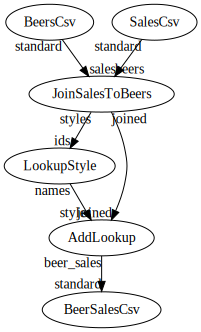

In [1]:
import graphviz

from graphviz import Digraph
dot = Digraph()

dot.node('BeersCsv')
dot.node('SalesCsv')
dot.node('JoinSalesToBeers')
dot.node('LookupStyle')
dot.node('AddLookup')
dot.node('BeerSalesCsv')

dot.edge('BeersCsv', 'JoinSalesToBeers', taillabel='standard', headlabel='sales')
dot.edge('SalesCsv', 'JoinSalesToBeers', taillabel='standard', headlabel='beers')
dot.edge('JoinSalesToBeers', 'LookupStyle', taillabel='styles', headlabel='ids')
dot.edge('JoinSalesToBeers', 'AddLookup', taillabel='joined', headlabel='joined')
dot.edge('LookupStyle', 'AddLookup', taillabel='names', headlabel='styles')
dot.edge('AddLookup', 'BeerSalesCsv', taillabel='beer_sales', headlabel='standard')


dot

#### Dask graph

All of the distinct transformations (e.g., reading/writing the CSVs, joining, lookup, and adding the lookup back to the data) are represented as "pipes".  A pipe is mostly a collection of data sources and data targets that can be executed to transform data from the sources to the targets.  Pipes can be connected to other pipes.  These connections
form a DAG that must be executed in the proper sequence.  Dask can be used to parallelize components that can be run
at the same time.

Calling DaskPipe BeersCsvPipe with ()
Executing BeersCsvPipe
Getting target standard from BeersCsvPipe: BeersCsvPipe-target-standard
connecting BeersCsvPipe-target-standard to JoinSalesToBeersPipe-source-beers
Calling DaskPipe SalesCsvPipe with ()
Executing SalesCsvPipe
Getting target standard from SalesCsvPipe: SalesCsvPipe-target-standard
connecting SalesCsvPipe-target-standard to JoinSalesToBeersPipe-source-sales
Calling DaskPipe JoinSalesToBeersPipe with ('BeersCsvPipe-target-standard', 'SalesCsvPipe-target-standard')
Executing JoinSalesToBeersPipe
Getting target styles from JoinSalesToBeersPipe: JoinSalesToBeersPipe-target-styles
connecting JoinSalesToBeersPipe-target-styles to LookupStylePipe-sources-ids
Calling DaskPipe LookupStylePipe with ('JoinSalesToBeersPipe-target-styles',)
Executing LookupStylePipe
Getting target names from LookupStylePipe: LookupStylePipe-targets-names
connecting LookupStylePipe-targets-names to AddLookupPipe-sources-style
Getting target joined from Join

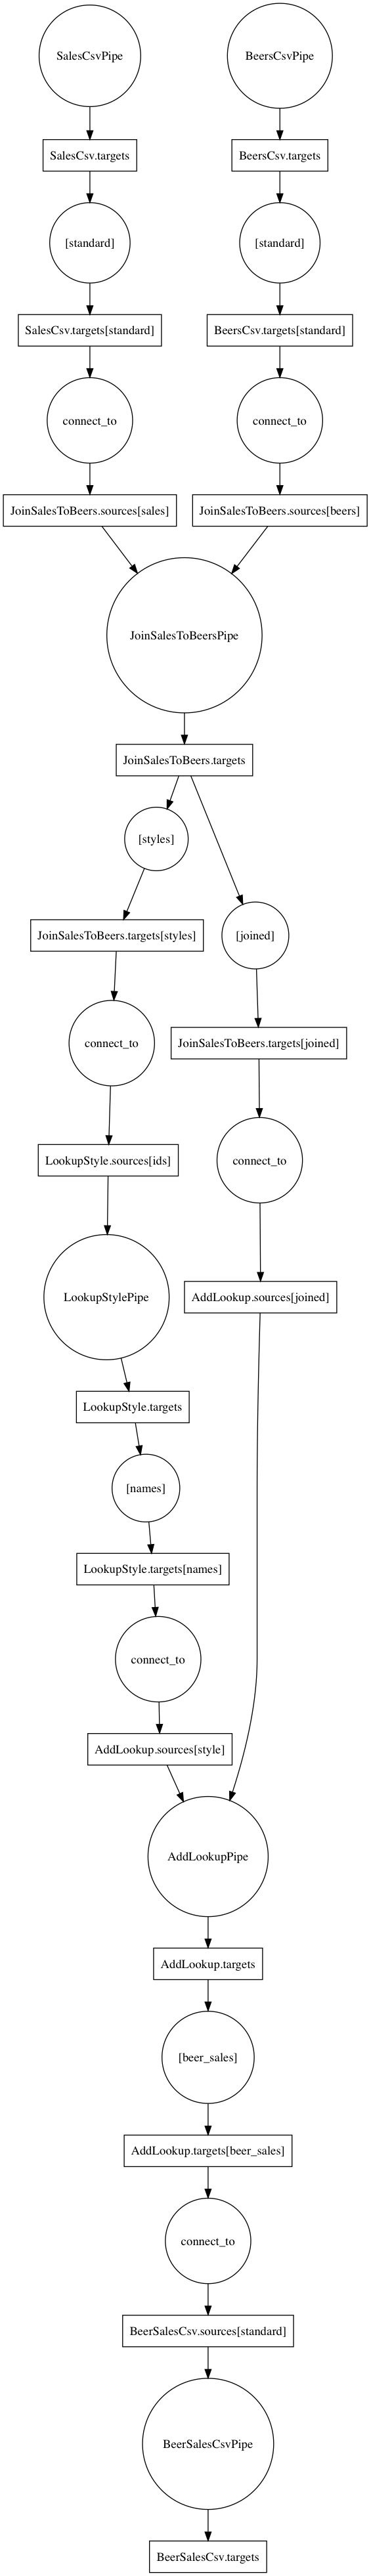

In [2]:
import dask

class Pipe():
    'A pipe is mostly a collection of data sources and data targets that is executed to move data from sources to targets.'
    def __init__(self, name):
        self.name = name
        self.sources = {}
        self.targets = {}
                
    def execute(self):
        print('Executing {}'.format(self.name))

class DaskPipe():
    'DaskPipe is just a wrapper around Pipe that allows us to use the Pipes in the context of Dask'
    def __init__(self, pipe):
        self.pipe = pipe
        
    def __call__(self, *args):
        print('Calling DaskPipe {} with {}'.format(self.pipe.name, args))
        self.pipe.execute()
        return self
        
    def __str__(self):
        return self.pipe.name
        
        
def connect(source):
    def _connect(target):
        print('connecting {} to {}'.format(target, source))
        return target
    _connect.__name__ = 'connect_to'
    return _connect

def get_target(name):
    def _get_target(daskpipe):
        print('Getting target {} from {}: {}'.format(name, daskpipe.pipe.name, daskpipe.pipe.targets[name]))
        return daskpipe.pipe.targets[name]
    _get_target.__name__ = '[{}]'.format(name)
    return _get_target

def get_source(name):
    def _get_source(daskpipe):
        print('Getting source {} from {}: {}'.format(name, daskpipe.pipe.name, daskpipe.pipe.sources[name]))
        return daskpipe.pipe.sources[name]
    _get_source.__name__ = '[{}]'.format(name)
    return _get_source

# Pipe definitions - These pipes don't actually do anything.  The only "transformation" they do is
# load strings into the targets.
beers_csv_pipe = DaskPipe(Pipe('BeersCsvPipe'))
beers_csv_pipe.pipe.targets = {
    'standard': 'BeersCsvPipe-target-standard'
}

sales_csv_pipe = DaskPipe(Pipe('SalesCsvPipe'))
sales_csv_pipe.pipe.targets = {
    'standard': 'SalesCsvPipe-target-standard'
}

join_sales_to_beers_pipe = DaskPipe(Pipe('JoinSalesToBeersPipe'))
join_sales_to_beers_pipe.pipe.sources = {
    'beers': 'JoinSalesToBeersPipe-source-beers',
    'sales': 'JoinSalesToBeersPipe-source-sales'
}
join_sales_to_beers_pipe.pipe.targets = {
    'joined': 'JoinSalesToBeersPipe-target-joined',
    'styles': 'JoinSalesToBeersPipe-target-styles'
}

lookup_style_pipe = DaskPipe(Pipe('LookupStylePipe'))
lookup_style_pipe.pipe.sources = {
    'ids': 'LookupStylePipe-sources-ids'
}
lookup_style_pipe.pipe.targets = {
    'names': 'LookupStylePipe-targets-names'
}

add_lookup_pipe = DaskPipe(Pipe('AddLookupPipe'))
add_lookup_pipe.pipe.sources = {
    'style': 'AddLookupPipe-sources-style',
    'joined': 'AddLookupPipe-sources-joined',
}
add_lookup_pipe.pipe.targets = {
    'beer_sales': 'AddLookupPipe-targets-beer_sales'
}

beer_sales_csv_pipe = DaskPipe(Pipe('BeerSalesCsvPipe'))
beer_sales_csv_pipe.pipe.sources = {
    'standard': 'BeerSalesCsvPipe-sources-standard'
}


# In practice, these graphs would be autogenerated based on simpler connection definitions
# Nodes are subjects and pipes are operations
d = {
    'BeersCsv.targets': (beers_csv_pipe, ),
    'BeersCsv.targets[standard]': (get_target('standard'), 'BeersCsv.targets'),
    'SalesCsv.targets': (sales_csv_pipe, ),
    'SalesCsv.targets[standard]': (get_target('standard'), 'SalesCsv.targets'),
    'JoinSalesToBeers.sources[beers]': (connect(join_sales_to_beers_pipe.pipe.sources['beers']), 'BeersCsv.targets[standard]'),
    'JoinSalesToBeers.sources[sales]': (connect(join_sales_to_beers_pipe.pipe.sources['sales']), 'SalesCsv.targets[standard]'),
    'JoinSalesToBeers.targets': (join_sales_to_beers_pipe, 'JoinSalesToBeers.sources[beers]', 'JoinSalesToBeers.sources[sales]'),
    'JoinSalesToBeers.targets[styles]': (get_target('styles'), 'JoinSalesToBeers.targets'),
    'JoinSalesToBeers.targets[joined]': (get_target('joined'), 'JoinSalesToBeers.targets'),
    'LookupStyle.sources[ids]': (connect(lookup_style_pipe.pipe.sources['ids']), 'JoinSalesToBeers.targets[styles]'),
    'LookupStyle.targets': (lookup_style_pipe, 'LookupStyle.sources[ids]'),
    'LookupStyle.targets[names]': (get_target('names'), 'LookupStyle.targets'),
    'AddLookup.sources[style]': (connect(add_lookup_pipe.pipe.sources['style']), 'LookupStyle.targets[names]'),
    'AddLookup.sources[joined]': (connect(add_lookup_pipe.pipe.sources['joined']), 'JoinSalesToBeers.targets[joined]'),    
    'AddLookup.targets': (add_lookup_pipe, 'AddLookup.sources[style]', 'AddLookup.sources[joined]'),
    'AddLookup.targets[beer_sales]': (get_target('beer_sales'), 'AddLookup.targets'),
    'BeerSalesCsv.sources[standard]': (connect(beer_sales_csv_pipe.pipe.sources['standard']), 'AddLookup.targets[beer_sales]'),
    'BeerSalesCsv.targets': (beer_sales_csv_pipe, 'BeerSalesCsv.sources[standard]')
}
from dask.dot import dot_graph
dask.get(d, 'BeerSalesCsv.targets')
dot_graph(d, rankdir='TB')